<a href="https://colab.research.google.com/github/jquesada92/Kaggle_Times_Series_Competition/blob/main/times_series_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from os import chdir
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
chdir('/content/drive/MyDrive/Notebooks/Time-Series/Kaggle_Times_Series_Competition')

In [3]:
! pip install wordcloud  &> /dev/null 
! pip install googletrans==4.0.0rc1 &> /dev/null 
! pip install nb_black &> /dev/null   
! pip install lifelines &> /dev/null

In [4]:
import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter, CoxPHFitter 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from wordcloud import WordCloud,  STOPWORDS
from sklearn.model_selection import TimeSeriesSplit

from googletrans import Translator

def month_diff(a, b):
    return 12 * (a.year - b.dt.year) + (a.month - b.dt.month)

%load_ext lab_black

# Description ✒️


# Data Description
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.
# **📚File descriptions**
* **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
* **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
* **sample_submission.csv** - a sample submission file in the correct format.
* **items.csv** - supplemental information about the items/products.
* **item_categories.csv**  - supplemental information about the items categories.
* **shops.csv**- supplemental information about the shops.

# **📁Data fields**
* **ID** - an Id that represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of item category
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category


In [5]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use('ggplot')

In [6]:
 
translator = Translator()
df_item_categories = pd.read_csv("input/item_categories.csv")
df_item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


The item category name is in Russian we going to use google translator to translate into english.

In [7]:
df_item_categories['category_name_eng']= df_item_categories.item_category_name.apply(lambda text: translator.translate(text, src='ru',dest='en').text)

In [8]:
df_item_categories.category_name_eng.unique()

array(['PC - headsets/headphones', 'Accessories - PS2',
       'Accessories - PS3', 'Accessories - PS4', 'Accessories - PSP',
       'Accessories - PSVITA', 'Accessories - Xbox 360',
       'Accessories - Xbox One', 'Tickets (number)', 'Delivery of goods',
       'Game consoles - PS2', 'Game consoles - PS3',
       'Game consoles - PS4', 'Game consoles - PSP',
       'Game consoles - PSVITA', 'Game consoles - Xbox 360',
       'Game consoles - Xbox One', 'Game consoles - others',
       'Games - PS2', 'Games - PS3', 'Games - PS4', 'Games - PSP',
       'Games - PSVITA', 'Games - Xbox 360', 'Games - Xbox One',
       'Games - accessories for games', 'Android games - number',
       'Mac games - digit', 'PC games - additional publications',
       'PC Games - Collectible Publications',
       'PC games - standard publications', 'PC games - digit',
       'Payment cards (cinema, music, games)', 'Payment cards - Live!',
       'Payment cards - Live!(Number)', 'Payment cards - PSN',
       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


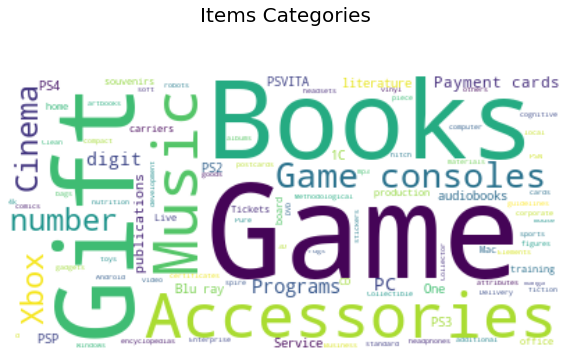

In [9]:
plt.figure(figsize=(8,6))
plt.imshow(
     WordCloud(stopwords = STOPWORDS, background_color="white").generate(" ".join(df_item_categories.category_name_eng.str.replace("\W+"," ").tolist()))
, interpolation='bilinear',  
 )
plt.axis("off")
plt.suptitle('Items Categories',size=20)
plt.tight_layout(pad=1)
plt.show()

In [10]:
split_item_name = df_item_categories.category_name_eng.str.split('-')
df_item_categories["product_type"] = split_item_name.apply(lambda x: x[0].strip())
df_item_categories["product_sub_type"] = split_item_name.apply(lambda x: x[1] if len(x)>1 else None)
df_item_categories.loc[lambda x: (~x.category_name_eng.str.upper().str.contains( "CONSOLE|PAYMENT|BOARD|ACCESSORIES" ))
            &(x.category_name_eng.str.upper().str.contains( "PC|PS\d|XBOX|PSP|ANDROID|PSVITA|MAC" ) )
            & (x.category_name_eng.str.upper().str.contains( "GAMES*" ) ) ,"product_type"] = 'Video Games'
df_item_categories.loc[lambda x: (~x.category_name_eng.str.upper().str.contains( "CONSOLE" ))
            &(x.category_name_eng.str.upper().str.contains( "PC|PS\d|XBOX|PSP|PSVITA" ) ) 
            &(x.category_name_eng.str.upper().str.contains( "ACCESSORIES" ) ),"product_type"] = 'Accessories consoles'
df_item_categories.loc[lambda x: x.category_name_eng.str.upper().str.contains( "BOOK" ),"product_type"] = 'Books'
df_item_categories.loc[lambda x: x.category_name_eng.str.upper().str.contains( "GIFTS - CARDS|PAYMENT\s*CARDS" ),"product_type"] = "Gifts cards"

In [11]:
df_item = pd.read_csv(
    "input/items.csv",)\
            .merge(df_item_categories
                                    ,on='item_category_id'
                                       ,how='inner'
                                           ,validate='m:1'
                      )
df_item.head()

,item_name,item_id,item_category_id,item_category_name,category_name_eng,product_type,product_sub_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Cinema - DVD,Cinema,DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Cinema - DVD,Cinema,DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Cinema - DVD,Cinema,DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Cinema - DVD,Cinema,DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Cinema - DVD,Cinema,DVD


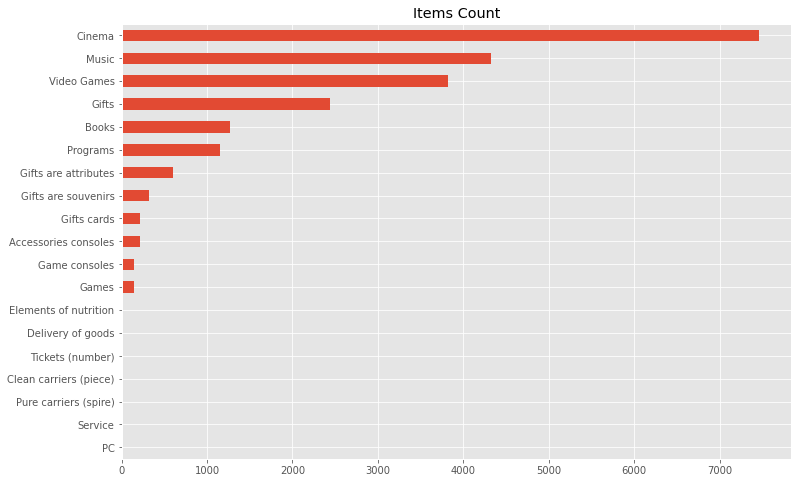

In [12]:
df_item.product_type.value_counts().sort_values().plot.barh(title='Items Count')
plt.show()

In [13]:
df_sales = pd.read_csv("input/sales_train.csv",parse_dates=['date'],dayfirst=True,infer_datetime_format=True,index_col='date')
df_sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.00,1.0
2013-01-03,0,25,2552,899.00,1.0
2013-01-05,0,25,2552,899.00,-1.0
2013-01-06,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


In [14]:
def month_diff(a, b):
    return 12 * (b.year - a.year) + (b.month - a.month)

In [15]:
df_agg_monthly_sales = df_sales.query('item_cnt_day>-1').reset_index().groupby(['item_id']).agg({'date':['min','max']})
df_agg_monthly_sales.columns = ['first_sale','last_sale']
df_agg_monthly_sales['months'] = df_agg_monthly_sales.apply(lambda x: month_diff(x.first_sale,x.last_sale),axis = 1)

In [16]:
df_monthly_sales = df_sales.groupby('item_id').resample('M').item_cnt_day.sum()\
.reset_index()\
.pivot_table(index= 'date',columns='item_id',values='item_cnt_day',aggfunc='sum')\
.reset_index()\
.melt(id_vars='date',value_name='item_cnt_month',var_name='item_id')\
.fillna(0)\
.merge(df_agg_monthly_sales,on=['item_id'],how='left')\
.query('date>=first_sale & date<=last_sale')\
.merge(df_item,on='item_id')\
.drop(['last_sale','first_sale','months'],axis=1)\
.assign(months = lambda _x: _x.groupby('item_id').date.transform(lambda x: month_diff(x.min(),x.dt)),
        last_months_of_sales = lambda _x: _x.groupby('item_id').date.transform(lambda x: x.max()==x))\
.sort_values(['item_id','date'], ascending = False )

In [17]:

df_monthly_sales.head()

,date,item_id,item_cnt_month,item_name,item_category_id,item_category_name,category_name_eng,product_type,product_sub_type,months,last_months_of_sales
286425,2013-08-31,22168,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports",7,True
286424,2013-07-31,22168,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports",6,False
286423,2013-06-30,22168,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports",5,False
286422,2013-05-31,22168,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports",4,False
286421,2013-04-30,22168,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports",3,False


In [18]:
first_date, last_date = df_monthly_sales.date.min(), df_monthly_sales.date.max()
print(f'first date: {first_date}\nlast date: {last_date}\nmonths: {month_diff(first_date,last_date)}')

first date: 2013-01-31 00:00:00
last date: 2015-10-31 00:00:00
months: 33


# Survival Analysis

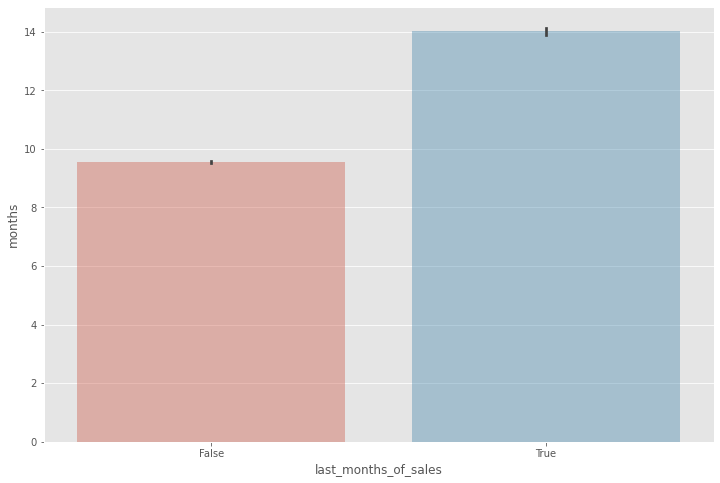

In [19]:
sns.barplot(data=df_monthly_sales,x='last_months_of_sales',y="months", alpha=.4)
plt.show()

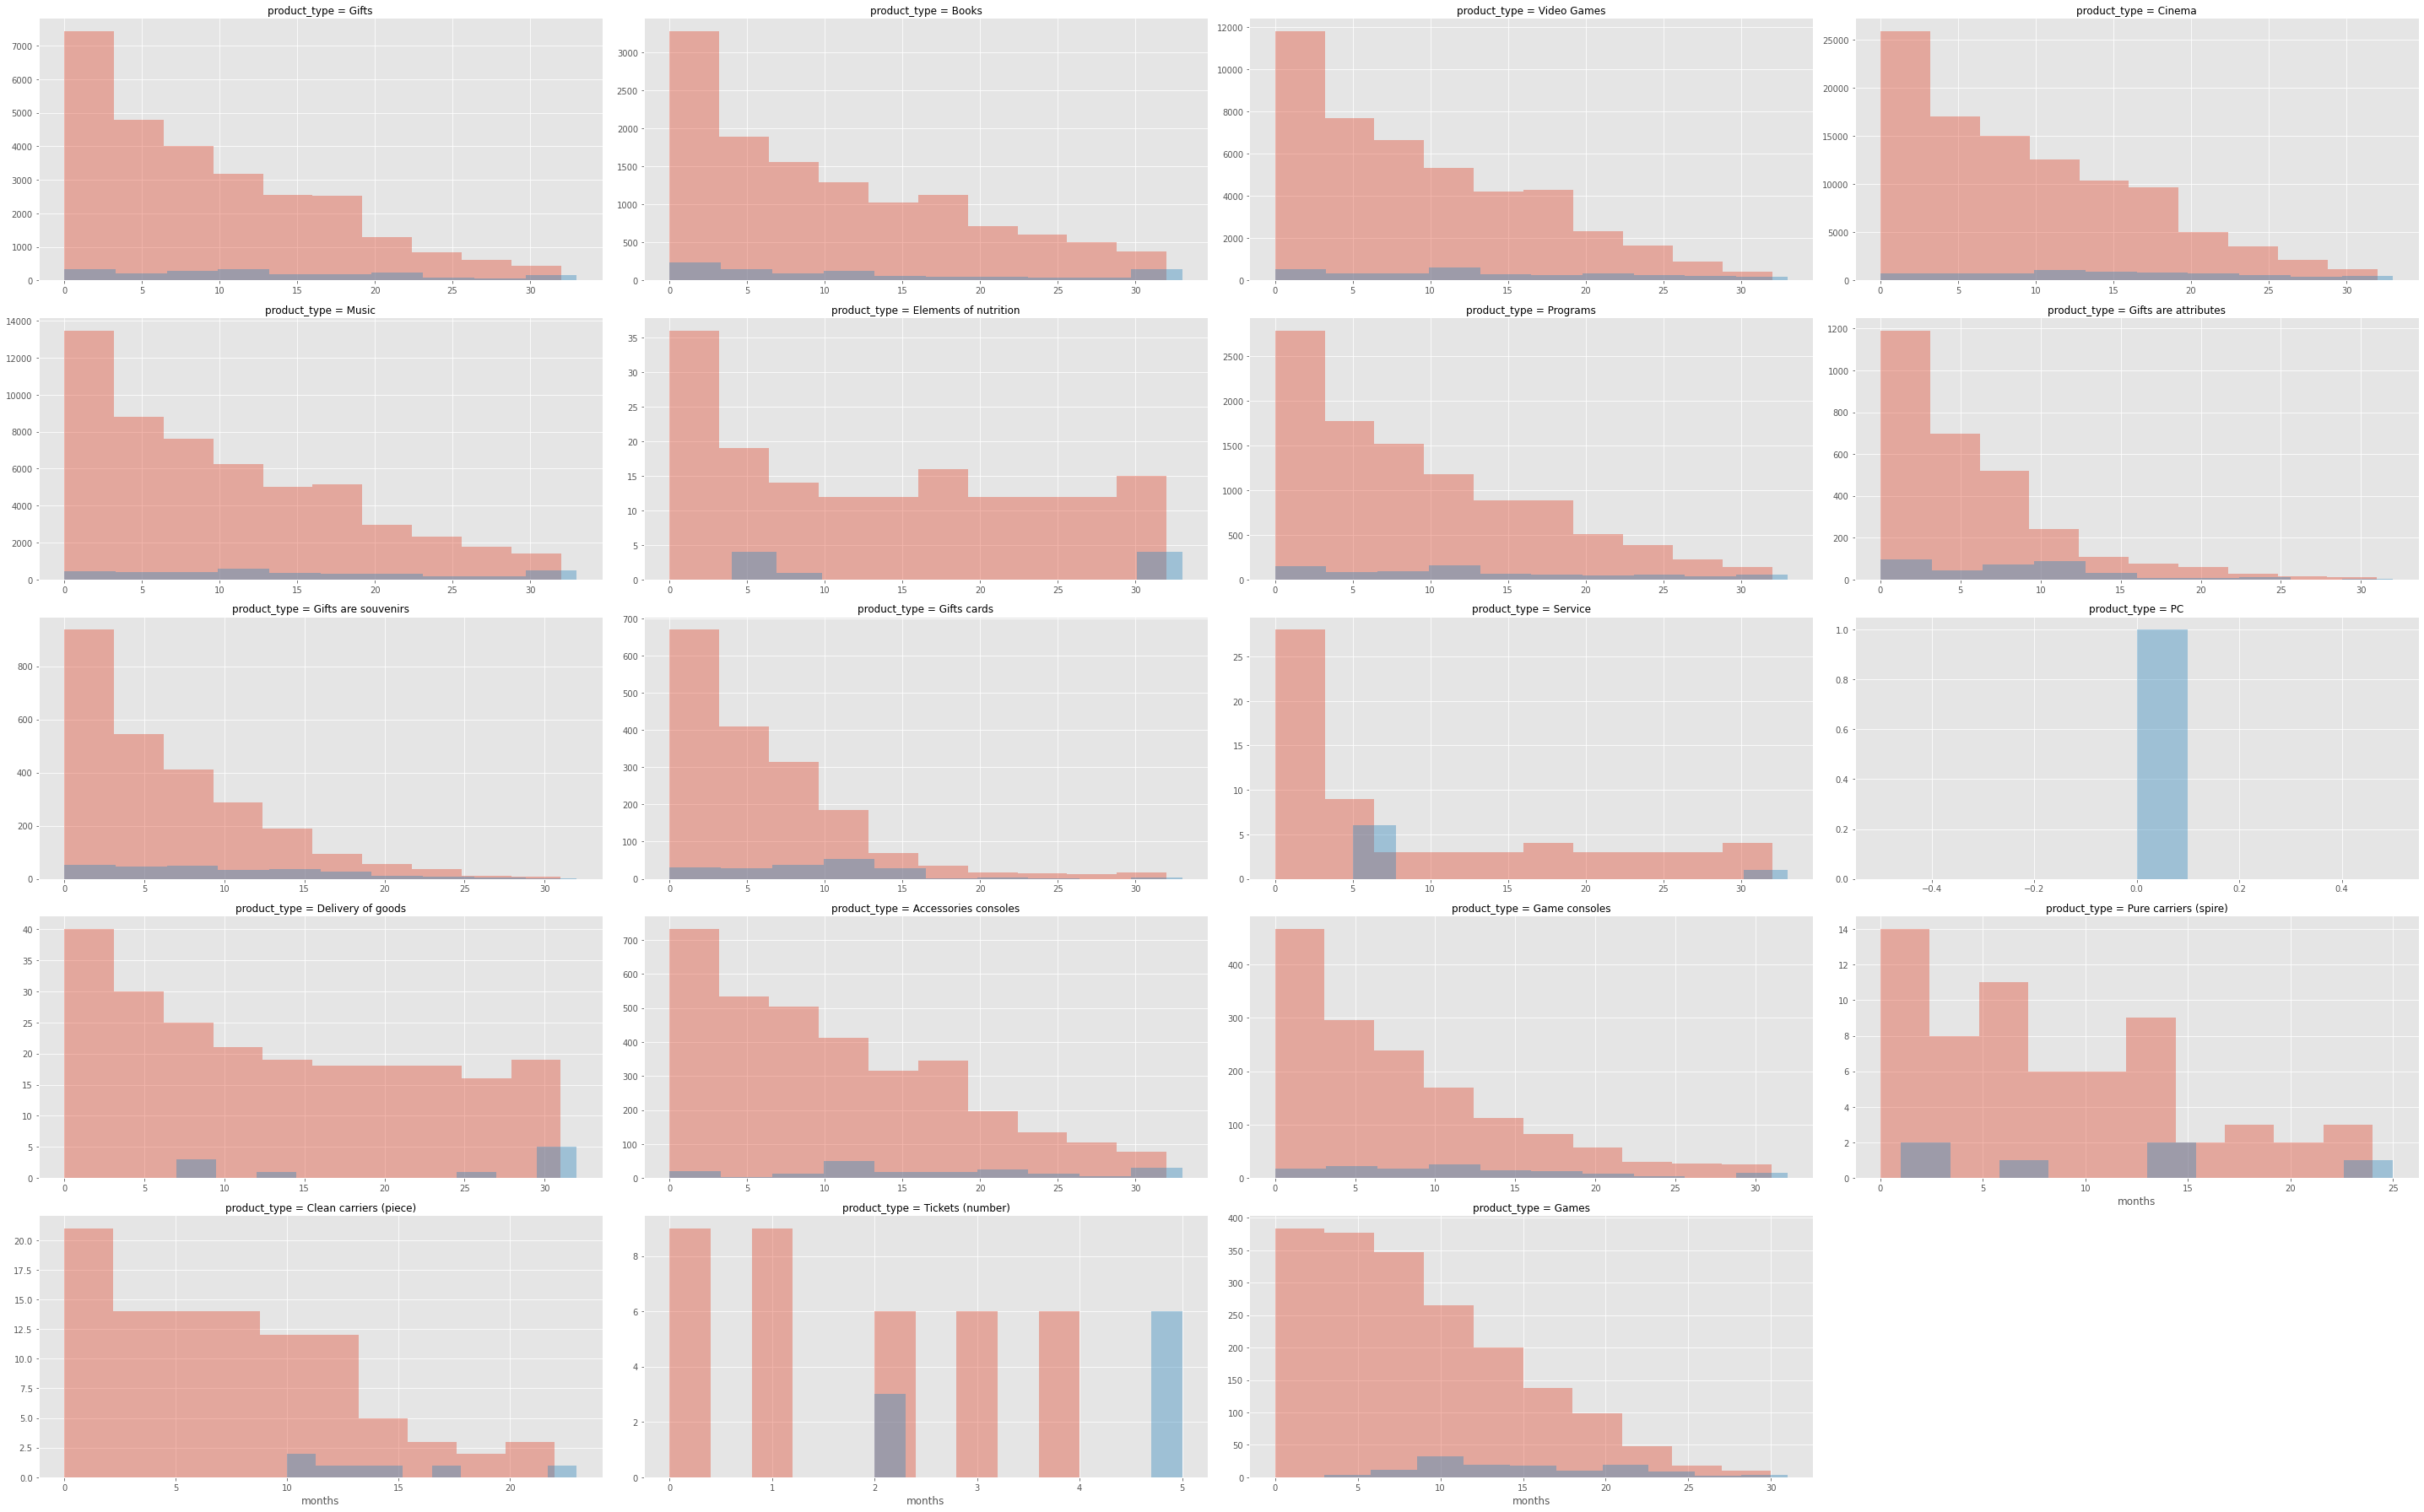

In [20]:
g = sns.FacetGrid(df_monthly_sales, hue="last_months_of_sales", col="product_type", col_wrap=4, sharex=False,sharey=False,aspect = 2, height= 5)
g.map(plt.hist, "months", alpha=.4)